# 作业第四周  CNN（2）网络练习

1.仿照课件关于deepdream的程序，在data目录选择一张背景图片(zju1.jpg或zju2.jpg或zju3.jpg或zju4.jpg或者用代码下载一张网络图片保存在save/目录)，
选取一个ImageNet预训练网络，通过选择以及组合不同的特征层，训练出一张自己满意的deepdream图片。<BR>



In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,1024)

Thu May 25 15:28:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 47%   49C    P2   116W / 350W |  21512MiB / 24268MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lflc8tpq because the default path (/home/student/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


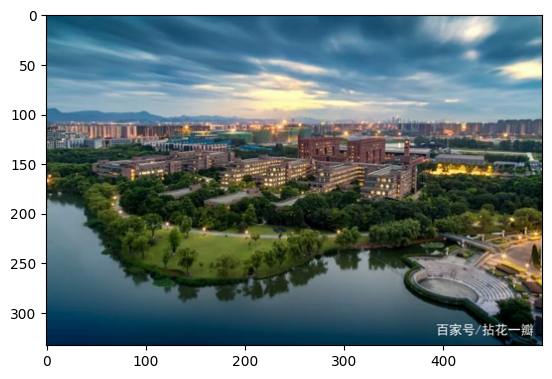

In [2]:
# 参考课程PPT， 使用Tensorflow 实现目标效果
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from tensorflow.keras.preprocessing import image
#归一化
def normalize_image(img):
    img = 255*(img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)
#图像展示
def show_image(img):
    plt.imshow(PIL.Image.fromarray(np.array(img)))
    plt.show()
    
#图片保存   
def save_image(img, file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)
#图片读取    
def read_image(file_name, max_dim = None):
    img = PIL.Image.open(file_name)
    if max_dim:
        img.thumbnail((max_dim,max_dim))
    return np.array(img)

img_file = 'data/zju2.jpg'
ori_img = read_image(img_file, 500)
show_image(ori_img)

In [3]:
#加载模型
img_noise = np.random.uniform(-1,1,size= (300,300,3))+100
img_blank = np.zeros(shape= (300,300,3))+100
base_model = tf.keras.applications.InceptionV3(include_top= False, weights= 'imagenet')
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [4]:
#选择提取层
#layer_names = 'conv2d_85'
#layers = base_model.get_layer(layer_names).output 
layer_names = ['mixed3','mixed5']
layers = [base_model.get_layer(name).output for name in layer_names]
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [5]:
#查看目标模型
dream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [6]:
#多通道综合损失函数
def calc_loss(img, model,channels=[13,139]):
    img = tf.expand_dims(img, axis = 0)
    layer_activations = model(img)
    losses = []
    for cn in channels:
        act = layer_activations[:,:,:,cn]
        loss = tf.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)
#全通道损失函数
def calc_loss1(img, model):
    img = tf.expand_dims(img, axis = 0)
    layer_activations = model(img)
    losses = []
    for act in layer_activations:
        loss = tf.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)
# 渲染函数
def render_deepdream(model, img, steps=100, step_size=0.01, verbose=1, channels=[13]): 
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            #loss = calc_loss(img, model, channels=channels)
            loss = calc_loss1(img, model)
        
        gradients = tape.gradient(loss, img)
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)
        
        if verbose == 1 :
            if (n+1)%10==0 :
                print("step {}/{}. loss {}".format(n+1, steps, loss))
                
    return img

step 10/200. loss 1.2067389488220215
step 20/200. loss 1.4933502674102783
step 30/200. loss 1.6692759990692139
step 40/200. loss 1.7993875741958618
step 50/200. loss 1.9026168584823608
step 60/200. loss 1.988472819328308
step 70/200. loss 2.0630595684051514
step 80/200. loss 2.1294307708740234
step 90/200. loss 2.190877914428711
step 100/200. loss 2.2449374198913574
step 110/200. loss 2.2953813076019287
step 120/200. loss 2.34199857711792
step 130/200. loss 2.385087013244629
step 140/200. loss 2.4268412590026855
step 150/200. loss 2.4668145179748535
step 160/200. loss 2.50423002243042
step 170/200. loss 2.540112018585205
step 180/200. loss 2.5743794441223145
step 190/200. loss 2.606200695037842
step 200/200. loss 2.638624668121338
time-duration21.87


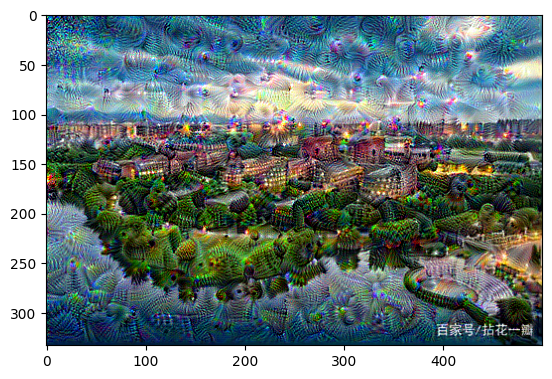

In [7]:
img = tf.keras.applications.inception_v3.preprocess_input(ori_img)
img = tf.convert_to_tensor(img)
import time
start = time.time()
dream_img = render_deepdream(dream_model,img,steps = 200,step_size = 0.01)
end = time.time()
print('time-duration%.2f'%(end-start))
dream_img = normalize_image(dream_img)
show_image(dream_img)

In [ ]:
#使用Pytorch 实现目标效果。
#由于内存限制，这里无法运行
#参考链接
#https://blog.csdn.net/weixin_53598445/article/details/123294868
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter, ImageChops
from torchvision import models
from torchvision import transforms

cache_dir = "save/3200100259/cache"
os.makedirs(cache_dir, exist_ok=True)  # 创建新的缓存目录

torch.hub.set_dir(cache_dir)  # 设置新的缓存目录路径

#下载图片
def load_image(path) :
    img = Image.open(path)
    return img

#因为在图像处理过程中有归一化的操作，所以要"反归一化"
def deprocess(image, device):
    image = image * torch.tensor([0.229, 0.224, 0.225], device = device) + torch.tensor([0.485, 0.456, 0.406], device = device)
    return image

#传入输入图像，正 向传播到VGG19的指定层，然后，用梯度上升更新 输入图像的特征值。
def prod(image, feature_layers, iterations, lr, transform, device, vgg, modulelist) :
    input = transform(image).unsqueeze(0)         #对图像进行resize，转成tensor和归一化操作，要增加一个维度，表示一个样本，[1, C, H, W]
    input = input.to(device).requires_grad_(True) #对图片进行追踪计算梯度
    vgg.zero_grad()                               #梯度清零
    for i in range(iterations) :
        out = input
        for j in range(feature_layers) :          #遍历features模块的各层
            out = modulelist[j + 1](out)          #以上一层的输出特征作为下一层的输入特征
        loss = out.norm()                         #计算特征的二范数
        loss.backward()                           #反向传播计算梯度，其中图像的每个像素点都是参数

        with torch.no_grad() :
            input += lr * input.grad              #更新原始图像的像素值

    input = input.squeeze()                       #训练完成后将表示样本数的维度去除
    # 交互维度
    # input = input.transpose(0, 1)
    # input = input.transpose(1, 2)
    input = input.permute(1, 2, 0)                #维度转换，因为tensor的维度是(C, H, W)，而array是(H, W, C)
    input = np.clip(deprocess(input, device).detach().cpu().numpy(), 0, 1)#将像素值限制在(0, 1)之间
    image = Image.fromarray(np.uint8(input * 255))#将array类型的图像转成PIL类型图像，要乘以255是因为转成tensor时函数自动除以了255
    return image

#多次缩小图像，然后调用函数 prod。接着在放大结果，并与按一定比例图像混合在一起，最终得到与输入 图像相同大小的输出图像。
#octave_scale参数决定了有多少个尺度的图像, num_octaves参数决定一共有多少张图像
#octave_scale和num_octaves两个参数的选定对生成图像的影响很大。
def deep_dream_vgg(image, feature_layers, iterations, lr, transform, device, vgg, modulelist, octave_scale = 2, num_octaves = 100) :
    if num_octaves > 0 :
        image1 = image.filter(ImageFilter.GaussianBlur(2))#高斯模糊
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1) :#当图像的大小小于octave_scale时图像尺度不再变化
            size = image1.size
        else :
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))

        image1 = image1.resize(size, Image.ANTIALIAS)#缩小图片
        image1 = deep_dream_vgg(image1, feature_layers, iterations, lr, transform, device, vgg, modulelist, octave_scale, num_octaves - 1)#递归
        size = (image.size[0], image.size[1])

        image1 = image1.resize(size, Image.ANTIALIAS)#放大图像
        image = ImageChops.blend(image, image1, 0.6) #按一定比例将图像混合在一起
        # PIL.ImageChops.blend(image1, image2, alpha)
        # out = image1 * (1.0 - alpha) + image2 * alpha
    img_result = prod(image, feature_layers, iterations, lr, transform, device, vgg, modulelist)
    img_result = img_result.resize(image.size)
    return img_result

    #对图像进行预处理
tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), #将PIL类型转成tensor类型，注意再次过程中像素值已经转到了[0, 1]之间，方式是除以255
    transforms.Normalize(mean = [0.485, 0.456, 0.406], #归一化
                            std = [0.229, 0.224, 0.225])
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg = models.vgg19(pretrained = True).to(device) 
    
modulelist = list(vgg.features.modules())#要注意网络层转成列表元素之后，第一个元素是全部的网络层，下标从1开始迭代网络层,这也是后面是modulelist[j + 1]的原因
night_sky = load_image('data/zju1.jpg')
night_sky_30 = deep_dream_vgg(night_sky, 36, 6, 0.2, tranform, device, vgg, modulelist)
plt.imshow(night_sky_30)
plt.show()